# Three Body Problem

Three bodies orbit under the influence of gravity.  In general, the motion is chaotic and no practical closed form solution is known.  In practice the problem can be solved using numerical integrators.<br>
See https://en.wikipedia.org/wiki/Three-body_problem for a detailed discussion on the theory and history of this problem.

In [1]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly, G_
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from jacobi import CartesianToJacobi, JacobiToCartesian

from g3b_data import make_traj_g3b, make_data_g3b, make_datasets_g3b, combine_datasets_g3b, traj_to_batch
from g3b_data import make_datasets_solar, make_datasets_hard
from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
from g3b import KineticEnergy_G3B, PotentialEnergy_G3B, Momentum_G3B, AngularMomentum_G3B
from g3b import VectorError, EnergyError
from g3b import Motion_G3B, make_physics_model_g3b
from g3b import fit_model
from g3b_model_math import make_position_model_g3b_math, make_model_g3b_math
from g3b_model_nn import make_position_model_g3b_nn, make_model_g3b_nn

In [3]:
# Set active GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[1:2], 'GPU')

In [4]:
# Grow GPU memory (must be first operation in TF)
# gpu_grow_memory()

In [5]:
# strat = tf.distribute.MirroredStrategy(['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3'])

In [6]:
# Lightweight serialization
fname = '../data/g3b/g3b.pickle'
vartbl = load_vartbl(fname)

### Orbital Elements Refresher

![title](../figs/web/orbital-elements.png)

**Variable Names of Six Keplerian Orbital Elements**
* `a` - semi-major axis; size of the ellipse; mean of periapsis and apoapsis distances
* `e` - eccentricity; shape of the ellipse.  e=0 is a circle, e=1 is a line.  $e^2 = 1 - b^2 / a^2$
* `inc` - inclination; angle between orbital and ecliptic planes
* `Omega` - longitude of the asending node; undefined when inc=0
* `omega` - argument of pericenter; true anomaly where body is closest to the primary.
* `f` - true anomaly; angle of the orbiting body in its orbital plane

**Two Additional Elements**
* `M` - mean anomaly; area swept out by the orbiting body, normalized so a full orbit is $2 \pi$.  Because of the rule of equal area in equal time, a.k.a. conservation of angular momentum, the mean anomly is linear in time
* `N` - mean motion; rate at which mean anomly changes, i.e. $2 \pi / T$ where $T$ is the orbital period

### Generate and Visualize One Example Orbital Path

The module `g3b_data.py` includes functions used to generate training data for the (general) three body problem.<br>
The function `make_traj_g3b` generates a single trajectory for the G3B problem.  It takes as inputs the masses of the three bodies, `m`; and the six traditional orbital elements (`a`, `e`, `inc`, `Omega`, `omega`, `f`).  The mass is an array of size 3, and each orbital element is an array of size 2.  Orbital elements describe the relationship between two bodies, or here the relationship between body i and the center of mass of bodies 0 through i-1.<br>
`make_traj_g3b` creates a new Rebound simulation with three particles: the sun and two orbiting bodies.  The sun has mass 1.0 in solar mass units, and initial position and velocity 0.<br>
The first orbiting body orbits around the primary (body 0, similar tot he sun) with initial position and velocity are assigned by Rebound based on the orbital elements.<br>
The second orbiting body orbits around the center of mass of body 0 and body 1.  In practice this will be very close to the primary.  This choice of coordinates is called Jacobi coordinates.<br>
The orbit is evaluated for a period of `n_years` with `sample_freq` observations per year.
Here I used 100 years and 10 observations per year, leading to 1001 data points counting both the start and end point.  The results are returned in two Dict objects named inputs and outputs.<br>
**Inputs**
* t - vector of times at which the orbit was sampled
* q0 - initial position of the bodies; shape (num_particles, space_dims,) = (3, 3,)
* v0 - initial velocity of the bodies; shape (num_particles, space_dims,) = (3, 3,)
* m - mass of the bodies in solar masses; shape (num_particles,) = (3,)

**Outputs**
* q - orbital positions of the bodies over time; shape (N, 3, 3,)
* v - orbital velocitiy of body 1 over time; shape (N, 3, 3,)
* a - orbital acceleration of body 1 over time;  shape (N, 3, 3,)
* q0_rec - recovered initial position of bodies; duplicate of q0_init
* v0_rec - recovered initial velocity of bodies; duplicate of v0_init
* T - the kinetic energy of the system; $T = \frac{1}{2} \sum_{i=1}^{3}{m_i |v_i|^2}$
* U - the potential energy of the system; 
$$U = \sum_{i=1}^{3}\sum_{j=i+1}^{3} \frac{-G m_i m_i}{r_{ij}}$$
where $r_{ij} = |qi - qj|$ is the distance between bodies $i$ and $j$
* H - the total energy in the system $H = T + U$
* P - the momentum, $P = \sum{m_i \cdot v_i}$
* L - the angular momentum, $L = \sum{q_i \times m_i v_i}$

In [7]:
# Generate one example trajectory with orbiting earth-like and jupiter-like planets
# https://ssd.jpl.nasa.gov/txt/p_elem_t1.txt
m = np.array([1.0, 1.0E-6, 1.0E-3])
a = np.array([1.00000, 5.2029])
e = np.array([0.0167, 0.0484])
inc = np.radians([0.00, 1.3044])
Omega = np.radians([0.00, 100.47])
omega = np.radians([102.94, 14.73]) - Omega
f = np.radians([100.46, 34.40]) - Omega
n_years = 100
sample_freq = 10

inputs_traj, outputs_traj = make_traj_g3b(m=m, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f, 
                                          n_years=n_years, sample_freq=sample_freq)

# Combined dict
data_traj = {**inputs_traj, **outputs_traj}

# Review the fields
print('Input fields:', list(inputs_traj.keys()))
print('Output fields:', list(outputs_traj.keys()))

Input fields: ['t', 'q0', 'v0', 'm']
Output fields: ['q', 'v', 'a', 'orb_a', 'orb_e', 'orb_inc', 'orb_Omega', 'orb_omega', 'orb_f', 'q0_rec', 'v0_rec', 'T', 'U', 'H', 'P', 'L']


In [8]:
# Plot style 
plot_style()

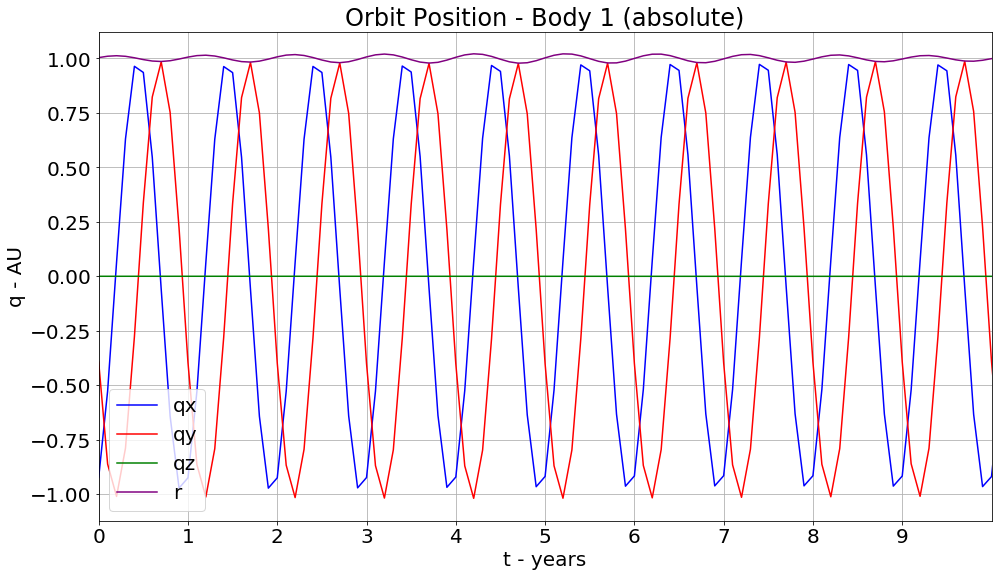

In [9]:
fig, ax = plot_orbit_q(data_traj, 1, False, 10.0)

In [ ]:
fig, ax = plot_orbit_energy(data_traj)

In [ ]:
fig, ax = plot_orbit_element(data_traj, 'a')

In [ ]:
# The eccentricity of body 1 has tiny wobbles that are barely visible
# fig, ax = plot_orbit_element(data_traj, 'e')

In [ ]:
# The inclination is rock solid
# fig, ax = plot_orbit_element(data_traj, 'inc')

In [ ]:
# The Omega parameter for body 1 looks like a decaying sine curve with; the spikes are an artifact of wrapping around +/- pi
# omega2 appears nearly constant.
# fig, ax = plot_orbit_element(data_traj, 'Omega')

In [ ]:
# The omega parameter for body 1 looks like a decaying sine curve; omega2 appears nearly constant.
fig, ax = plot_orbit_element(data_traj, 'omega')

In [ ]:
# The true anomaly f looks like a staircase that is equivalent to a straight line mod two pi
# The wobbles comapred to the mean anomaly are not visible on this scale
# fig, ax = plot_orbit_element(data_traj, 'f')

### Generate Training Data with a Range of Orbital Parameters

The function `make_train_g3b` creates training data for the general 3 body problem in the form of dictionaries of numpy arrays.  These are analogous to the outputs of `make_traj_r3b`, but there is an outer index of `n_traj` different trajectories.  The inputs `m_min` and `m_max` control the mass range of bodies 2 and 3 solar units; the first body always has mass equal to 1 solar unit.<br>
The inputs `a_min`, `a_max`, `e_max`, and `inc_max` determine the sampling ranges for the parameters `a`, `e` and `inc` of the orbital elements of the starting configuration. <br>
The other orbital elements (`Omega`, `omega`, `f`) are sampled over the full range of admissible values.<br>
The function `make_datasets_r3b` generates three tensorflow Dataset objects for train, validation and test, respectively.  Data is generated in the form of Numpy arrays using `make_train_g3b` because it is easier to serialize in that format.  The function checks on disk to see if the data is already available, and if so, loads it.  Otherwise it generates and then saves it.  Effective serialization is critical because the data set is expensive to generate.

In [ ]:
# Inputs for make_train_g3b
m_min = 1.0E-7
m_max = 2.0E-3
n_traj = 10
n_years = 100
sample_freq = 10
a_min = 0.50
a_max = 32.0
e_max = 0.08
inc_max = 0.04
seed = 42

In [ ]:
# Test make_data_g3b
# inputs, outputs= make_data_g3b(n_traj=n_traj, n_years=n_years, sample_freq=sample_freq,
#                                a_min=a_min, a_max=a_max, e_max=e_max, inc_max=inc_max, seed=seed)

In [ ]:
# Inputs for make_datasets_g3b
vt_split = 0.20
n_years = 100
sample_freq = 10

# The batch size
batch_size = 64
num_gpus = 1
full_batch_size = batch_size * num_gpus

In [ ]:
# Create a tiny data set with 64 solar type orbits
n_traj = 64
ds_tiny_trn, ds_tiny_val, ds_tiny_tst = make_datasets_solar(n_traj=n_traj, vt_split=1.0, 
                                                            n_years=n_years, sample_freq=sample_freq)

In [ ]:
# Create a medium data set with 10,000 solar type orbits
n_traj = 10000

ds_small_trn, ds_small_val, ds_small_tst = make_datasets_solar(n_traj=n_traj, vt_split=vt_split, 
                                                               n_years=n_years, sample_freq=sample_freq,
                                                               batch_size = full_batch_size)

In [ ]:
# Create a large data set with 50,000 solar type orbits
# n_traj = 50000

# ds_large_trn, ds_large_val, ds_large_tst = make_datasets_solar(n_traj=n_traj, vt_split=vt_split, 
#                                                                n_years=n_years, sample_freq=sample_freq)

In [ ]:
# Create a list of medium data sets
n_traj = 10000
num_data_sets = 50
seeds = list(range(42, 42+3*num_data_sets, 3))

# Load big combined dataset
ds_trn, ds_val, ds_tst = combine_datasets_g3b(
    n_traj=n_traj, vt_split=vt_split, n_years=n_years, sample_freq=sample_freq,
    m_min=m_min, m_max=m_max, a_min=a_min, a_max=a_max,
    e_max=e_max, inc_max=inc_max, seeds=seeds, batch_size=full_batch_size)

***Generating 14,000 trajectories takes about 52 minutes on my server and uses about 2.68 GB of disk space.***<br>
***Generating 70,000 trajectories takes about 265 minutes (4:25) and uses about 13.42 GB of disk space***<br>
***Generating 50 medium data sets each with 70,000 trajectories took 45 hours and uses about 134 GB of disk space.***
Pace is about 4.5 trajectories per second. Storage requirements about 145 KB / trajectory.<br>

### Review One Example Batch of Training Data

In [ ]:
# Example batch
# batch_in, batch_out = list(ds_small_trn.take(1))[0]
batch_in, batch_out = list(ds_tiny_trn.take(1))[0]
batch_tiny_in, batch_tiny_out = batch_in, batch_out
print('Input field names: ', list(batch_in.keys()))
print('Output field names:', list(batch_out.keys()))
# inputs
t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
m = batch_in['m']
# outputs - trajectory
q = batch_out['q']
v = batch_out['v']
a = batch_out['a']
q0_rec = batch_out['q0_rec']
v0_rec = batch_out['v0_rec']
# outputs - orbital elements
orb_a = batch_out['orb_a']
orb_e = batch_out['orb_e']
orb_inc = batch_out['orb_inc']
orb_Omega = batch_out['orb_Omega']
orb_omega = batch_out['orb_omega']
orb_f = batch_out['orb_f']
# outputs - physics
H = batch_out['H']
P = batch_out['P']
L = batch_out['L']

print(f'\nExample batch sizes:')
print(f't  = {t.shape}')
print(f'q0 = {q0.shape}')
print(f'v0 = {v0.shape}')
print(f'm  = {m.shape}')

print(f'q  = {q.shape}')
print(f'v  = {v.shape}')
print(f'a  = {a.shape}')
# print(f'q0_rec = {q0_rec.shape}')
# print(f'v0_rec = {v0_rec.shape}')
print(f'H  = {H.shape}')
print(f'P  = {P.shape}')
print(f'L  = {L.shape}')

### Custom Keras Layers with Physics Computations of Energy and Angular Momentum

The module `g3b.py` contains shared elements used in the general 3 body problem.<br>
The layer `KineticEnergy_G3B` computes the kinetic energy of the system given the object masses `m` with shape (3,) and the velocities `v` with shape (traj_size, 3, 3).<br>
The kinetetic energy is $T = \frac{1}{2} \sum m_i |v_i|^2$ <br>
The layer `PotentialEnergy_G3B` computes the potential energy of the system given the masses `m` and the positions `q` with shape (traj_size, 3, 3).  <br>
The potential energy 
$$U = -\sum_{i<j}{\frac{G m_i m_j}{r_{ij}}}$$ 
where $r_{ij} = |q_j - q_i|$. For the 3 body problem there are ${3}\choose{2} = 3$ interaction pairs.<br>
The layer `Momentum_G3B` computes the momentum of the system given its masses `m`, and velocity `v`. This quantity will be constant by conservation of momentum.  In the center of momentum frame adopted by convention, both the momentum and center of mass will be the zero vector.<br>
The momentum $P = \sum m_i v_i$<br>
The layer `AngularMomentum_G3B` computes the angular momentum of the system given its masses `m`, position `q` and velocity `v`.<br>
The angular momentum $L = \sum q_i \times m_i v_i$, the 3D vector cross product.

In addition to the custom layers computing the physical quantities, there are also custom loss functions intended to be used with them.<br>
The custom loss function `VectorError` returns the relative error 
$$E = \frac{|y_{true} - y_{pred}|}{|y_{true}| + R}$$
where $R$ is an optional regularization term that defaults to 0.<br>
The custom loss function `EnergyError` returns a log scaled squared error
$$E = \log{\left[1 + \left(\frac{y_{pred} - y_{true}}{y_{true}}\right)^2\right]}$$
The log scaling is introduced so that the error doesn't blow up catastrophically when distance gets too small.  This was causing problems in training when an un-scaled energy error was used.

**Call layers with physics computations**

In [ ]:
T = KineticEnergy_G3B()([m, v])
T.shape

In [ ]:
U = PotentialEnergy_G3B()([m, q])
U.shape

In [ ]:
P = Momentum_G3B()([m, v])
P.shape

In [ ]:
L = AngularMomentum_G3B()([m, q, v])
L.shape

## Convert Initial Configuration from Cartesian to Jacobi Coordinates

In [ ]:
# Compute the Jacobi coordinates of the initial conditions
qj0, vj0, mu0 = CartesianToJacobi(include_accel=False)([m, q0, v0])

In [ ]:
# Review shape of Jacobi inputs
print(f'Shape of q0 : {q0.shape}')
print(f'Shape of v0:  {v0.shape}')
print(f'Shape of m:   {m.shape}')

# Review shape of Jacobi outputs
print(f'Shape of qj0: {qj0.shape}')
print(f'Shape of vj0: {vj0.shape}')
print(f'Shape of mu0: {mu0.shape}')

In [ ]:
# qj0[0]

In [ ]:
# vj0[0]

In [ ]:
# Check that the round trip back to Cartesian coordinates is consistent
q0_rec, v0_rec = JacobiToCartesian()([m, qj0, vj0])

# Compute errors
rms = lambda x : np.sqrt(np.mean(np.square(x)))

err_q0 = q0_rec - q0
err_v0 = v0_rec - v0
rms_q0 = rms(err_q0)
rms_v0 = rms(err_v0)

# Display errors
print(f'RMS Error in q0_rec: {rms_q0:5.3e}')
print(f'RMS Error in v0_rec: {rms_v0:5.3e}')

***The round trip between Jacobi to Cartesian coordinates is very accurate with losses on the order of 1E-7.***

## Convert Jacobi Coordinates to Orbital Elements

In [ ]:
# Extract Jacobi coordinates of p1 and p2

# Initial position qj0
qj0_1 = qj0[:, 1, :]
vj0_1 = vj0[:, 1, :]

# Initial velocity qv0
qj0_2 = qj0[:, 2, :]
vj0_2 = vj0[:, 2, :]

# Gravitational field strength for orbital element conversion of p1 and p2
mu0_1 = mu0[:, 1:2]
mu0_2 = mu0[:, 2:3]

In [ ]:
# Tuple of inputs for the model converting from configuration to orbital elements
cfg_1 = (qj0_1, vj0_1, mu0_1)
cfg_2 = (qj0_2, vj0_2, mu0_2)

In [ ]:
# Model mapping cartesian coordinates to orbital elements
model_c2e = make_model_cfg_to_elt()

In [ ]:
# Extract the orbital elements of the initial conditions
a1_0, e1_0, inc1_0, Omega1_0, omega1_0, f1_0, M1_0, N1_0 = model_c2e(cfg_1)
a2_0, e2_0, inc2_0, Omega2_0, omega2_0, f2_0, M2_0, N2_0 = model_c2e(cfg_2)

In [ ]:
# Model mapping orbital elements to cartesian coordinates
model_e2c = make_model_elt_to_cfg()

In [ ]:
# Attempt to recover the original Jacobi coordinates
qj0_1_rec, vj0_1_rec = model_e2c([a1_0, e1_0, inc1_0, Omega1_0, omega1_0, f1_0, mu0_1])
qj0_2_rec, vj0_2_rec = model_e2c([a2_0, e2_0, inc2_0, Omega2_0, omega2_0, f2_0, mu0_2])

In [ ]:
# Error in recovered Jacobi coordinates - position qj0
err_qj0_1 = qj0_1_rec - qj0_1
err_qj0_2 = qj0_2_rec - qj0_2
err_qj0 = np.concatenate([err_qj0_1, err_qj0_2])
rms_qj0 = rms(err_qj0)

# Error in recovered Jacobi coordinates - velocity vj0
err_qj0_1 = qj0_1_rec - qj0_1
err_qj0_2 = qj0_2_rec - qj0_2
err_qj0 = np.concatenate([err_qj0_1, err_qj0_2])
rms_qj0 = rms(err_qj0)

# Display errors
print(f'RMS Error in recovered initial Jacobi position qj0_rec:\n{rms_qj0:5.3e}')
print(f'RMS Error in recovered initial Jacobi velocity vj0_rec:\n{rms_v0:5.3e}')

***The round trip from Jacobi coordinates, to orbital elements, and back is very accurate with losses on the order of 1E-6.***

## Kepler-Jacobi Model for the Three Body Problem

Approximate the motion as coupled Kepler two body problems using Jacobi coordinates.

**Position Model: Compute q over time with Orbital Elements and Kepler's Equation**<br>
In the next section, we instantiate a mathematical position model.

In [ ]:
n_years = 100
sample_freq = 10
traj_size = n_years * sample_freq + 1

In [ ]:
position_model_math = make_position_model_g3b_math(traj_size=traj_size, batch_size=batch_size, num_gpus=1)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1.0E-3)

loss_pos = {'q': VectorError(name='q_loss'),
            'v': VectorError(name='v_loss'),
            'a': VectorError(name='a_loss')}

metrics = None

loss_weights_pos = {'q': 1.0,
                    'v': 1.0,
                    'a': 1.0}

In [ ]:
# Compile the position model
position_model_math.compile(optimizer=optimizer, loss=loss_pos, metrics=metrics, loss_weights=loss_weights_pos)

In [ ]:
# # Compile the mathematical model for parallel GPUs
# with strat.scope():
#     position_model_math2 = make_position_model_g3b_math(traj_size=traj_size, 
#                                                         batch_size=batch_size, num_gpus=num_gpus)
#     position_model_math2.compile(optimizer=optimizer, loss=loss_pos, metrics=metrics, loss_weights=loss_weights_pos)

In [ ]:
# Test the position model on the tiny data set
position_model_math.evaluate(ds_tiny_trn)

In [ ]:
# Test the position model on the example batch; 
# b/c the tiny set has 100 elements it only has 1 batch when dropping remainders
# so the output should be the same as with evaluate(ds_tiny_trn)
position_model_math.test_on_batch(batch_in, batch_out)

In [ ]:
# Test the position model on the small data set
position_model_math.evaluate(ds_small_trn)

In [ ]:
q_pos, v_pos, a_pos = position_model_math([t, q0, v0, m])
print('shape of position_model outputs:')
print(f'q_pos: {q_pos.shape}')
print(f'v_pos: {v_pos.shape}')

In [ ]:
# Compute RMS error in recovered position
num_body=3
q_err = q_pos - q
v_err = v_pos - v
q_rms_err = rms(q_err)
v_rms_err = rms(v_err)
print(f'Position RMS error: {q_rms_err:5.2e}')
print(f'Velocity RMS error: {v_rms_err:5.2e}')

In [ ]:
# Compute RMS error in recovered initial position; should be nearly zero
q0_err = np.linalg.norm(q_err[:,0,:,:], axis=(1,2,))
# Index with max error
idx_q = np.argmax(q0_err)

# Print error in q0
print(f'RMS Error in q0: {rms(q0_err):5.2e}')
print(f'Max error in q0 at index {idx_q} = {q0_err[idx_q]:5.2e}')
# q0_err

In [ ]:
# Compute RMS error in recovered initial velocity; should be nearly zero
v0_err = np.linalg.norm(v_err[:,0,:,:], axis=(1,2,))
# Index with max error
idx_v = np.argmax(v0_err)

# Print error in v0
print(f'RMS Error in v0: {rms(v0_err):5.2e}')
print(f'Max error in v0 at index {idx_v} = {v0_err[idx_v]:5.2e}')
# q0_err

***The position model recovers the initial position and velocity with very high accuracy, on the order of 1E-6***<br>
The accuracy drifts lower over 100 years because the 2 body approximation breaks down.

**Motion Model: Compute v and a from q using automatic differentiation**<br>
In the next section, we instantiate a motion model using mathematical position model.

In [ ]:
motion_model_math = Motion_G3B(position_model=position_model_math, name='motion_model')

In [ ]:
q_mot, v_mot, a_mot = motion_model_math([t, q0, v0, m])
print('shape of motion_model outputs:')
print(f'q_mot: {q_mot.shape}')
print(f'v_mot: {v_mot.shape}')
print(f'a_mot: {a_mot.shape}')

In [ ]:
# Compare v_mot with v_pos
vel_err = v_mot - v_pos

# Compute RMS error
v_rms_err = np.sqrt(np.mean(vel_err**2))
v_rel_err = v_rms_err / np.sqrt(np.mean(v_pos**2))
print(f'RMS error of recovered velocity from automatic differentiation vs. orbital elements:')
print(f'{v_rms_err:5.2E}')
print(f'Relative error of recovered velocity from automatic differentiation vs. orbital elements:')
print(f'{v_rel_err:5.2E}')

***Velocity computed by automatic differentiation is extremely close to velocity from stable orbital elements,
with differences on the order of 1E-7***

In [ ]:
loss_mot = {'q': VectorError(name='q_loss'),
            'v': VectorError(name='v_loss'),
            'a': VectorError(name='a_loss')}

loss_weights_mot = {'q': 1.0,
                    'v': 1.0,
                    'a': 1.0}

In [ ]:
# Compile the motion model
motion_model_math.compile(optimizer=optimizer, loss=loss_mot, metrics=metrics, loss_weights=loss_weights_mot)

In [ ]:
# Test the position model on the tiny data set
# motion_model_math.evaluate(ds_tiny_trn)

**Full physics model: computes energy, momentum and angular momentum from m, q, v**<br>
In the next section, we instantiate a full physics model from the same mathematical position model.<br>
This model is evloving the G3B system using Kepler's Equation and computing the physical quantities.
It is an approximate solution only that treats the 3 body system as two 2 body systems described in Jacobi coordinates.
Body 1 orbits around the primary in the first system.  Body 2 orbits around the center of mass of body 1 in the second system.  The second system is simplified by replacing the primary and body 1 with their combined center of mass.

In [ ]:
# model_math = make_physics_model_g3b(position_model=position_model_math, traj_size=traj_size)

In [ ]:
model_math = make_model_g3b_math(traj_size=traj_size)

## Review outputs of math model

In [ ]:
q, v, a, q0_rec, v0_rec, H, P, L = model_math([t, q0, v0, m])
print(f'model output shapes:')
print(f'q = {q.shape}')
print(f'v = {v.shape}')
print(f'a = {a.shape}')
print(f'q0_rec = {q0_rec.shape}')
print(f'v0_rec = {v0_rec.shape}')
print(f'H = {H.shape}')
print(f'P = {P.shape}')
print(f'L = {L.shape}')

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1.0E-3)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'P': VectorError(name='P_loss', regularizer=1.0),
        'L': VectorError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'P': 1.0,
                'L': 1.0}

In [ ]:
# Compile the full mathematical model
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# Evaluate the math model on the small data set
model_math.evaluate(ds_tiny_trn)

In [ ]:
# Evaluate the math model on the small data set
model_math.evaluate(ds_small_trn)

***The Kepler-Jacobi model is surprisingly accurate on solar-type systems.<br>***
Because the central mass is so dominant (planetary masses are logarithmically sampled between 1E-7 and 2E-3 solar masses),
approximating the 3 body system as coupled 2 body systems with Jacobi coordinates achieves MSE for position and velocity on the order of 5.0E-3 AU or AU / year, consistent with RMS errors around 0.07.  Not bad for a 100 year forecast!<br>
The losses on the physical quantities are all negible.  This is because the modeling approach preserves physical quantities including energy, momentum and angular momentum, and the orbital elements are capable of matching the initial conditions to very high accuracy.

**Summary of Accuracy for earth-jupiter type systems as masses vary:**<br>
When the mass is small (e.g. 1E-6 on both planets), 100 years of simulations is very accurate.<br>
Mean position error is 1.78E-6; accuracy trend is 5.6E-7 to 1.2E-5.<br>
When the mass is large (e.g. 1E-2 on both planets), 100 years of simulations have declining accuracy, but are still quite close. <br>
Mean position error is 4.15E-3; accuracy trend is 7.2E-7 to 2.5E-2.<br>
With approximate solar system values (1E-3, 1E-6), 100 years of simulation are a good approximation.<br>
Mean position error is 2.53E-4; accuracy trend 1.23E-6 to 1.42E-3.

## Simple Neural Network Model Based on Kepler-Jacobi Model

This neural network model is based on starting with an approximate solution using the Kepler-Jacobi model.<br>
The neural network is designed to learn how to adjust the orbital elements to improve the accuracy of the solution.<br>
The network design is along the following lines:
* The initial position and velocity are converted to Jacobi coordinates qj and vj
* The initial orbital elements a0, e0, inc0, Omega0, omega0, f0, N0, M0 are extracted from the Jacobi coordinates
* The orbit is simulated over time using the Kepler-Jacobi model.
    * The 5 orbital elements a, e, inc, Omega, omega remain
    * The mean anomaly is linear in time with slope given by the mean motion $N_0$
    * The true anomaly is computed from the mean anomaly using Kepler's Equation $M = E - e \sin (E)$
* The following features, which remain constant for an orbit, are collected into an initial batch of features:<br>
phi_traj = [a0, e0, inc0, Omega0, omega0, N0]
* These features are then copied to match the shape of the output, i.e. duplicated traj_size times in the appropriate axis
* The initial feature layer phi_0 consists of [t, phi_traj, M, f], where M and f are the computed mean anomaly and true anomaly over time
* The first hidden layer phi_1 has as an input phi_0.  The size is an argument to the model building function.
* The outputs of phi_1 are combined with phi_0, i.e. phi_1 = [phi_0, phi_1]
* The second hidden layer phi_2 has an input of phi_1.  The size is an argument to the model building function.
* The outputs of phi_2 are combined with phi_1, i.e. phi_2 = [phi_1, phi_2]
* There are six layers to compute the orbital elements a, e, inc, Omega, omega, f as a function of time.  These accept as inputs phi_n, the last output layer above.  (It can be phi_0, phi_1, or phi_2 depending on the specified input size.)
* The calculated orbital elements are transformed minimally to ensure that they are legal: a must be non-negative and e in [0, 1].
* The orbital elements are transformed into Cartesian Jacobi coordinates for the trajectory
* The Jacobi coordinates are transformed back to Cartesian coordinates for the 2 bodies

In [ ]:
# Configuration for neural network model
hidden_sizes = [64, 16]
# hidden_sizes = []
skip_layers = True
traj_size = 1001
batch_size = 64

In [ ]:
# Build neural network model
model_nn = make_model_g3b_nn(hidden_sizes=hidden_sizes, skip_layers=skip_layers, traj_size=traj_size)

In [ ]:
# position_model_nn.summary()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=2.0E-5)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0E-2, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'P': VectorError(name='P_loss', regularizer=1.0E-4),
        'L': VectorError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'P': 1.0,
                'L': 1.0}

In [ ]:
# Compile the NN model
model_nn.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# # Create a list of medium data sets
# n_traj = 10000
# # num_data_sets = 50
# num_data_sets = 10
# seeds = list(range(42, 42+3*num_data_sets, 3))

# # Load big combined dataset
# ds_trn, ds_val, ds_tst = combine_datasets_g3b(
#     n_traj=n_traj, vt_split=vt_split, n_years=n_years, sample_freq=sample_freq,
#     m_min=m_min, m_max=m_max, a_min=a_min, a_max=a_max,
#     e_max=e_max, inc_max=inc_max, seeds=seeds, batch_size=batch_size)

In [ ]:
# Evaluate the NN model on the tiny training data
model_nn.evaluate(ds_tiny_trn)

In [ ]:
# Evaluate the NN model on the small training data
model_nn.evaluate(ds_small_trn)

In [ ]:
# Evaluate the NN model on the full training data
model_nn.evaluate(ds_trn)

In [ ]:
# Set up training
suffix = '_'.join(str(sz) for sz in hidden_sizes)
model_name = f'model_g3b_nn_{suffix}'
model_h5 = f'../models/g3b/{model_name}.h5'
hist_name = model_name.replace('model_', 'hist_')
epochs = 1
save_freq = 'epoch'

In [ ]:
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = fit_model(model=model_nn, 
                     ds=ds_tiny_trn, 
                     epochs=epochs,
                     loss=loss, 
                     optimizer=optimizer,
                     metrics=metrics,
                     save_freq=save_freq,
                     prev_history = None, 
                     batch_num=0)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
num_epochs = 50
for i in range(num_epochs):
    ts = datetime.datetime.now()
    st = ts.strftime('%Y-%m-%d %H:%M:%S')
    print(f'*** Training loop {i+1:3} *** - {st}')
    hist = fit_model(model=model_nn, 
                     ds=ds_trn, 
                     epochs=epochs,
                     loss=loss, 
                     optimizer=optimizer,
                     metrics=metrics,
                     save_freq=save_freq,
                     prev_history = hist, 
                     batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
model_nn.evaluate(ds_small_trn)

In [ ]:
fig, ax = plot_loss_hist(hist, '[64, 16]')

In [ ]:
best_epoch = np.argmin(hist['q_loss'])
print(f'Best epoch: {best_epoch}')

In [ ]:
hist['q_loss'][best_epoch]

In [ ]:
hist['q_loss'][0]

In [ ]:
model_nn.evaluate(ds_trn)

In [ ]:
model_nn.evaluate(ds_tst)

In [ ]:
model_math.evaluate(ds_trn)

In [ ]:
model_math.evaluate(ds_tst)